# Shape Loss Experiment: Sculpting Objects from Noise

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jtooates/blind_lm/blob/main/experiments/shape_loss_experiment.ipynb)

This notebook demonstrates how the object-forming losses can create shape-like patterns from pure Gaussian noise.

**Key Idea**: We optimize pixel values directly (no neural network) using only loss functions as guidance.

**What you'll see**: Random noise → distinct blob-like shapes with sharp boundaries

## Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

print(f"PyTorch version: {torch.__version__}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

PyTorch version: 2.2.2
Using device: cpu


## Loss Functions

These are the same losses used in the single-channel training:

In [2]:
def create_shape_losses(latent):
    """
    Create losses that encourage shape-like structures.
    
    Args:
        latent: [B, H, W] tensor to optimize
    
    Returns:
        dict of loss components
    """
    B, H, W = latent.shape
    losses = {}
    
    # 1. Sparsity - most pixels should be background (near 0)
    losses['sparsity'] = torch.mean(torch.abs(latent))
    
    # 2. Binary-ness - pixels should be either on or off
    distance_from_binary = torch.min(
        (latent - 1.0)**2,  # Distance from 1
        (latent + 1.0)**2   # Distance from -1
    )
    losses['binary'] = torch.mean(distance_from_binary)
    
    # 3. Smoothness within objects (Total Variation)
    dx = torch.abs(latent[:, 1:, :] - latent[:, :-1, :])
    dy = torch.abs(latent[:, :, 1:] - latent[:, :, :-1])
    losses['tv'] = torch.mean(dx) + torch.mean(dy)
    
    # 4. Object size - encourage ~20% of pixels to be bright
    threshold = 0.5
    binary_mask = (latent > threshold).float()
    bright_ratio = torch.mean(binary_mask)
    target_ratio = 0.2
    losses['object_size'] = (bright_ratio - target_ratio)**2
    
    # 5. Magnitude - prevent collapse to near-zero values
    magnitude = torch.mean(torch.abs(latent))
    min_magnitude = 0.3
    losses['magnitude'] = torch.relu(min_magnitude - magnitude)
    
    return losses


def coherence_loss_autocorr(latent):
    """
    Spatial Autocorrelation Loss (fully differentiable).
    
    Encourages nearby pixels to have similar values → coherent blobs.
    High autocorrelation = coherent; low = scattered.
    
    Args:
        latent: [B, H, W] tensor
    
    Returns:
        loss value (we want to maximize autocorr, so return negative)
    """
    # Compute correlation between adjacent pixels
    dx = latent[:, 1:, :] * latent[:, :-1, :]  # Horizontal neighbors
    dy = latent[:, :, 1:] * latent[:, :, :-1]  # Vertical neighbors
    
    autocorr = torch.mean(dx) + torch.mean(dy)
    
    # Maximize autocorrelation = minimize negative
    return -autocorr


def coherence_loss_perimeter(latent, threshold=0.5, temperature=0.1):
    """
    Perimeter-to-Area Loss (differentiable via soft thresholding).
    
    Minimizes edge length relative to area.
    Scattered pixels: high perimeter/area → high loss
    Compact blobs: low perimeter/area → low loss
    
    Args:
        latent: [B, H, W] tensor
        threshold: threshold for "on" pixels
        temperature: softness of sigmoid (lower = sharper)
    
    Returns:
        perimeter-to-area ratio
    """
    # Soft thresholding (differentiable approximation)
    binary_soft = torch.sigmoid((latent - threshold) / temperature)
    
    # Compute edges (boundaries)
    dx = torch.abs(binary_soft[:, 1:, :] - binary_soft[:, :-1, :])
    dy = torch.abs(binary_soft[:, :, 1:] - binary_soft[:, :, :-1])
    
    # Total edge length
    edge_length = torch.sum(dx) + torch.sum(dy)
    
    # Total area (number of "on" pixels)
    area = torch.sum(binary_soft) + 1e-6  # Avoid division by zero
    
    # Minimize ratio (compact shapes have low ratio)
    return edge_length / area


def coherence_loss_morphological(latent):
    """
    Morphological Smoothness Loss (fully differentiable).
    
    Applies max pooling to fill in gaps.
    Scattered pixels differ a lot from smoothed version.
    Coherent blobs differ little from smoothed version.
    
    Args:
        latent: [B, H, W] tensor
    
    Returns:
        MSE between original and morphologically smoothed
    """
    # Add channel dimension for pooling
    latent_4d = latent.unsqueeze(1)  # [B, 1, H, W]
    
    # Smooth via max pooling (fills in small gaps)
    pooled = F.max_pool2d(latent_4d, kernel_size=3, stride=1, padding=1)
    
    # Inverse smoothing (min pooling via negation)
    unpooled = -F.max_pool2d(-pooled, kernel_size=3, stride=1, padding=1)
    
    # Remove channel dimension
    unpooled = unpooled.squeeze(1)
    
    # Scattered pixels differ; coherent blobs don't
    return torch.mean((latent - unpooled) ** 2)


def contrastive_shape_loss(latents):
    """
    Contrastive loss: different latents should look different.
    """
    B = latents.shape[0]
    if B < 2:
        return torch.tensor(0.0)
    
    # Flatten and normalize
    flat = latents.reshape(B, -1)
    flat_norm = F.normalize(flat, dim=1)
    
    # Compute similarity matrix
    sim_matrix = torch.matmul(flat_norm, flat_norm.T)
    
    # Penalize similarity between different samples
    mask = 1.0 - torch.eye(B).to(latents.device)
    loss = torch.mean(torch.abs(sim_matrix) * mask)
    
    return loss

print("✓ Loss functions defined")
print("\nAvailable coherence losses:")
print("  1. autocorr      - Spatial autocorrelation (simplest)")
print("  2. perimeter     - Perimeter-to-area ratio (most intuitive)")
print("  3. morphological - Max pooling smoothness")

✓ Loss functions defined

Available coherence losses:
  1. autocorr      - Spatial autocorrelation (simplest)
  2. perimeter     - Perimeter-to-area ratio (most intuitive)
  3. morphological - Max pooling smoothness


## Initialize Random Noise

We start with Gaussian noise + a few random blob seeds to break symmetry:

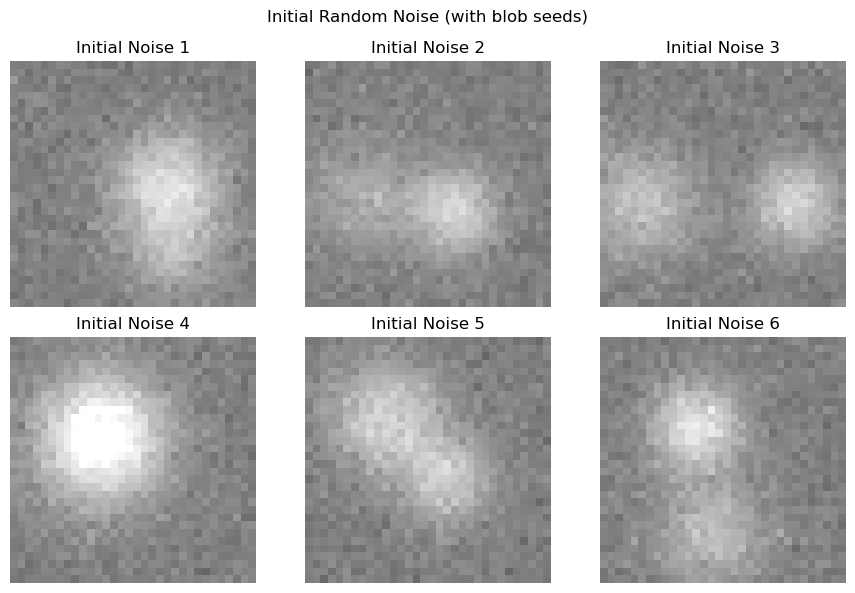

✓ Initialized 6 latents of shape torch.Size([32, 32])


In [3]:
def initialize_latents(batch_size=6, image_size=(32, 32), device='cpu'):
    """
    Initialize latents with structured noise.
    """
    H, W = image_size
    latents = []
    
    for i in range(batch_size):
        # Start with weak noise
        noise = torch.randn(H, W) * 0.1
        
        # Add a few random blobs to break symmetry
        for _ in range(2):
            y = np.random.randint(5, H-5)
            x = np.random.randint(5, W-5)
            size = np.random.randint(3, 7)
            
            yy, xx = torch.meshgrid(
                torch.arange(H) - y,
                torch.arange(W) - x,
                indexing='ij'
            )
            blob = torch.exp(-(yy**2 + xx**2) / (2 * size**2))
            noise += blob * np.random.uniform(0.5, 1.5)
        
        latents.append(noise)
    
    latents = torch.stack(latents).to(device)
    latents.requires_grad_(True)
    
    return latents

# Initialize
batch_size = 6
latents = initialize_latents(batch_size=batch_size, device=device)

# Visualize initial state
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
axes = axes.flatten()

for i in range(batch_size):
    axes[i].imshow(latents[i].detach().cpu().numpy(), cmap='gray', vmin=-1.5, vmax=1.5)
    axes[i].set_title(f'Initial Noise {i+1}')
    axes[i].axis('off')

plt.suptitle('Initial Random Noise (with blob seeds)')
plt.tight_layout()
plt.show()

print(f"✓ Initialized {batch_size} latents of shape {latents.shape[1:]}")

## Configure Loss Weights

**Try adjusting these!** Different weights create different types of patterns:

In [4]:
# Loss weights - EXPERIMENT WITH THESE!
weights = {
    'sparsity': 0.0,       # Lower = allows brighter pixels (was 0.5)
    'binary': 0.0,         # Higher = sharper boundaries (was 0.3)
    'tv': 0.0,            # Lower = allows sharper edges (was 0.1)
    'object_size': 0.0,    # Higher = enforces target size more (was 1.0)
    'magnitude': 0.0,      # NEW - prevents collapse to zero
    'contrastive': 2.0,    # Higher = more diverse patterns
}

# Choose coherence loss type (comment/uncomment to experiment)
coherence_type = 'autocorr'      # Options: 'autocorr', 'perimeter', 'morphological', None
coherence_weight = 2.0

# Optimization settings
num_steps = 300
learning_rate = 0.02

print("Loss weights:")
for name, weight in weights.items():
    print(f"  {name:15s}: {weight:.2f}")

if coherence_type:
    print(f"  {'coherence':15s}: {coherence_weight:.2f} (type: {coherence_type})")
else:
    print(f"  {'coherence':15s}: disabled")

print(f"\nOptimization: {num_steps} steps @ lr={learning_rate}")

print("\n" + "="*60)
print("COHERENCE LOSS OPTIONS:")
print("="*60)
print("'autocorr'       - Encourages nearby pixels to be similar")
print("                   (simplest, fully differentiable)")
print()
print("'perimeter'      - Minimizes edge length / area ratio")
print("                   (most intuitive, uses soft thresholding)")
print()
print("'morphological'  - Penalizes difference from max-pooled version")
print("                   (medium complexity)")
print()
print("None             - No coherence loss (may get scattered pixels)")
print("="*60)

Loss weights:
  sparsity       : 0.00
  binary         : 0.00
  tv             : 0.00
  object_size    : 0.00
  magnitude      : 0.00
  contrastive    : 2.00
  coherence      : 2.00 (type: autocorr)

Optimization: 300 steps @ lr=0.02

COHERENCE LOSS OPTIONS:
'autocorr'       - Encourages nearby pixels to be similar
                   (simplest, fully differentiable)

'perimeter'      - Minimizes edge length / area ratio
                   (most intuitive, uses soft thresholding)

'morphological'  - Penalizes difference from max-pooled version
                   (medium complexity)

None             - No coherence loss (may get scattered pixels)


## Run Optimization

Watch the noise transform into shapes!

In [5]:
# Re-initialize latents for fresh start
latents = initialize_latents(batch_size=batch_size, device=device)

# Optimizer
optimizer = torch.optim.Adam([latents], lr=learning_rate)

# Track losses
loss_history = []
coherence_history = []

print("Starting optimization...\n")

for step in range(num_steps):
    optimizer.zero_grad()
    
    # Compute shape losses
    shape_losses = create_shape_losses(latents)
    contrast_loss = contrastive_shape_loss(latents)
    
    # Compute coherence loss based on selected type
    if coherence_type == 'autocorr':
        coherence_loss = coherence_loss_autocorr(latents)
    elif coherence_type == 'perimeter':
        coherence_loss = coherence_loss_perimeter(latents)
    elif coherence_type == 'morphological':
        coherence_loss = coherence_loss_morphological(latents)
    else:
        coherence_loss = torch.tensor(0.0)
    
    # Total weighted loss
    total_loss = 0
    for name, loss in shape_losses.items():
        total_loss += loss * weights.get(name, 0.1)
    total_loss += contrast_loss * weights.get('contrastive', 1.0)
    
    if coherence_type:
        total_loss += coherence_loss * coherence_weight
    
    # Optimize
    total_loss.backward()
    optimizer.step()
    
    # Clamp to valid range
    with torch.no_grad():
        latents.clamp_(-1.5, 1.5)
    
    loss_history.append(total_loss.item())
    coherence_history.append(coherence_loss.item() if coherence_type else 0.0)
    
    # Print progress
    if step % 50 == 0:
        print(f"Step {step:3d}/{num_steps}: Loss = {total_loss.item():.4f}")
        print(f"  sparsity: {shape_losses['sparsity'].item():.4f}")
        print(f"  binary: {shape_losses['binary'].item():.4f}")
        print(f"  tv: {shape_losses['tv'].item():.4f}")
        print(f"  object_size: {shape_losses['object_size'].item():.4f}")
        print(f"  magnitude: {shape_losses['magnitude'].item():.4f}")
        print(f"  contrastive: {contrast_loss.item():.4f}")
        if coherence_type:
            print(f"  coherence ({coherence_type}): {coherence_loss.item():.4f}")
        print()

print("\n✓ Optimization complete!")

Starting optimization...

Step   0/300: Loss = 0.1389
  sparsity: 0.2830
  binary: 0.6250
  tv: 0.2423
  object_size: 0.0000
  magnitude: 0.0170
  contrastive: 0.4394
  coherence (autocorr): -0.3699

Step  50/300: Loss = -3.9871
  sparsity: 0.9648
  binary: 0.1972
  tv: 0.4970
  object_size: 0.0595
  magnitude: 0.0000
  contrastive: 0.0687
  coherence (autocorr): -2.0623

Step 100/300: Loss = -7.2870
  sparsity: 1.4029
  binary: 0.2441
  tv: 0.4308
  object_size: 0.0859
  magnitude: 0.0000
  contrastive: 0.0688
  coherence (autocorr): -3.7123

Step 150/300: Loss = -7.7534
  sparsity: 1.4681
  binary: 0.2491
  tv: 0.3609
  object_size: 0.0928
  magnitude: 0.0000
  contrastive: 0.0668
  coherence (autocorr): -3.9434

Step 200/300: Loss = -7.8600
  sparsity: 1.4813
  binary: 0.2491
  tv: 0.3356
  object_size: 0.0941
  magnitude: 0.0000
  contrastive: 0.0626
  coherence (autocorr): -3.9927

Step 250/300: Loss = -7.9082
  sparsity: 1.4849
  binary: 0.2494
  tv: 0.3232
  object_size: 0.0939


## Visualize Results

See the optimized shapes:

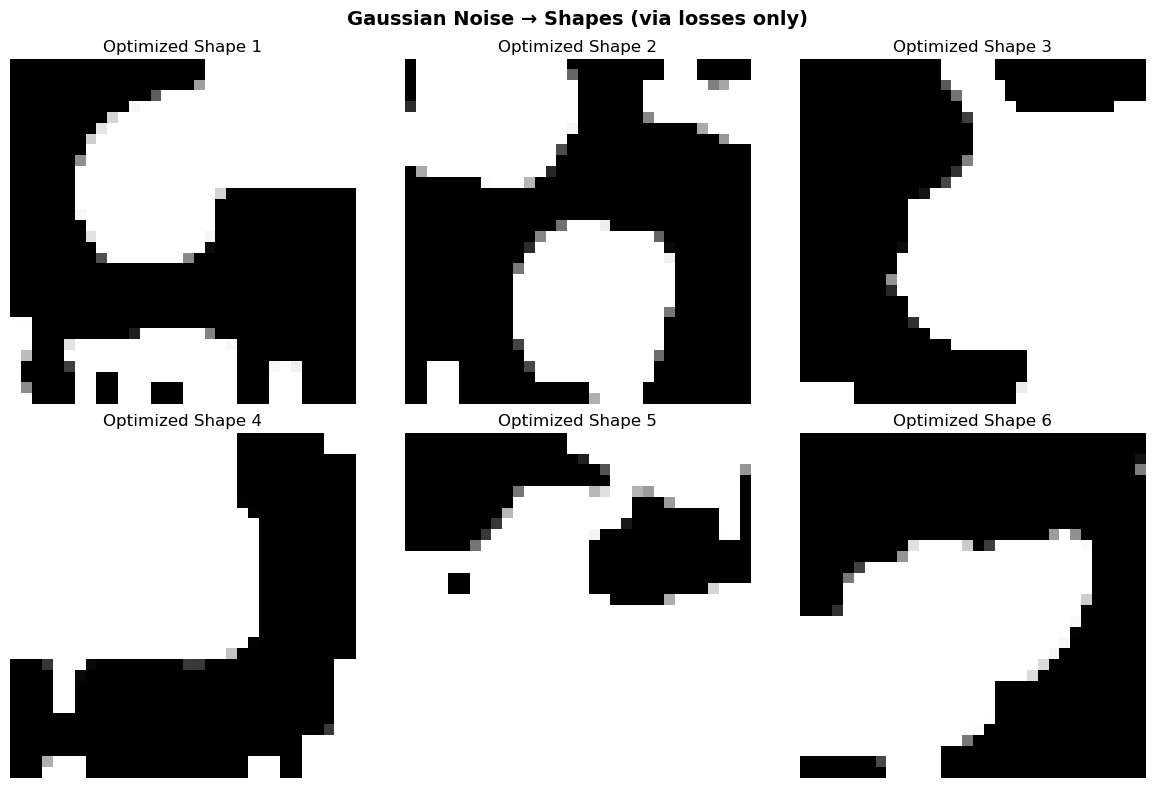

Notice:
  - Distinct blob-like shapes
  - Sharp boundaries between black/white
  - Sparse (mostly black background)
  - Each shape is different (contrastive loss)


In [6]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i in range(batch_size):
    img = latents[i].detach().cpu().numpy()
    axes[i].imshow(img, cmap='gray', vmin=-1.5, vmax=1.5)
    axes[i].set_title(f'Optimized Shape {i+1}', fontsize=12)
    axes[i].axis('off')

plt.suptitle('Gaussian Noise → Shapes (via losses only)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Notice:")
print("  - Distinct blob-like shapes")
print("  - Sharp boundaries between black/white")
print("  - Sparse (mostly black background)")
print("  - Each shape is different (contrastive loss)")

## Plot Loss Curve

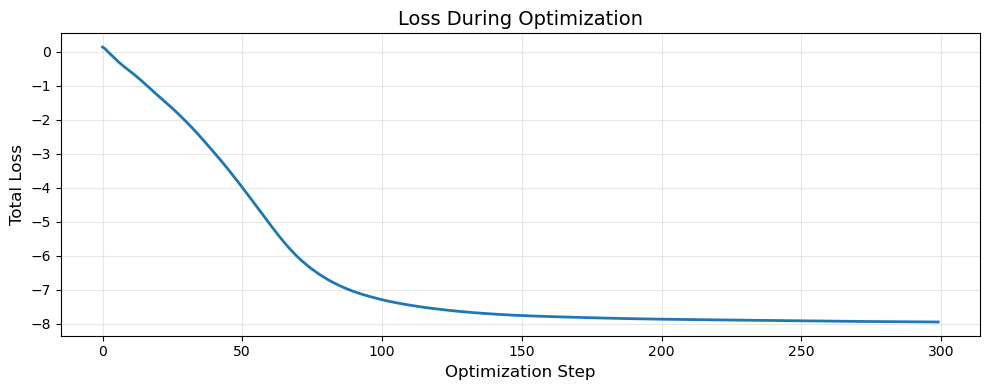

Final loss: -7.9420
Initial loss: 0.1389
Reduction: 5818.8%


In [7]:
plt.figure(figsize=(10, 4))
plt.plot(loss_history, linewidth=2)
plt.xlabel('Optimization Step', fontsize=12)
plt.ylabel('Total Loss', fontsize=12)
plt.title('Loss During Optimization', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final loss: {loss_history[-1]:.4f}")
print(f"Initial loss: {loss_history[0]:.4f}")
print(f"Reduction: {(1 - loss_history[-1]/loss_history[0])*100:.1f}%")

## Experiment: Try Different Coherence Losses

Go back to the "Configure Loss Weights" cell and try different `coherence_type` values:

### Coherence Loss Comparison

**`coherence_type = 'autocorr'`** (Spatial Autocorrelation):
- Encourages nearby pixels to have similar values
- Creates smooth, connected blobs
- Fully differentiable, no hyperparameters
- **Recommended starting point**

**`coherence_type = 'perimeter'`** (Perimeter-to-Area Ratio):
- Minimizes edge length relative to area (like surface tension)
- Creates compact, circular blobs
- Most geometrically intuitive
- Uses soft thresholding with `temperature` parameter

**`coherence_type = 'morphological'`** (Max Pooling Smoothness):
- Penalizes pixels that disappear after smoothing
- Creates robust blobs that survive pooling
- Medium complexity

**`coherence_type = None`** (No coherence):
- May result in scattered pixels instead of blobs
- Useful for comparison to see coherence effect

### Other Loss Weight Experiments

**More magnitude** (higher `magnitude` weight):
- Prevents collapse to near-zero values
- Forces stronger signals

**More binary** (higher `binary` weight):
- Sharper black/white contrast
- Less gray values

**More coherence** (higher `coherence_weight`):
- Larger, more connected blobs
- Fewer scattered pixels

**Less sparsity** (lower `sparsity` weight):
- Allows more pixels to be active
- Larger or more numerous objects

## Key Takeaway

This experiment shows that **you don't need paired image-text data** to get image-like patterns.

The right combination of losses can **sculpt structure out of noise** purely through optimization pressure.

This is exactly what the text encoder learns to do:
1. Map text → visual latent space
2. Minimize these object-forming losses
3. Naturally creates interpretable object-like patterns
4. Different text → different shapes (via contrastive loss)
5. Reconstruction loss ensures information is preserved

Comparing coherence losses: None vs autocorr vs perimeter vs morphological

Initial latents (before optimization):



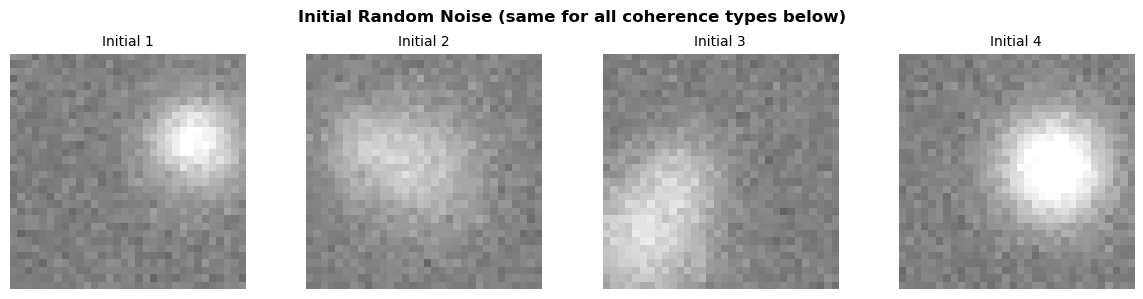


Optimizing with different coherence losses...

Training with coherence_type = None...
  ✓ Complete

Training with coherence_type = autocorr...
  ✓ Complete

Training with coherence_type = perimeter...
  ✓ Complete

Training with coherence_type = morphological...
  ✓ Complete

RESULTS AFTER 200 STEPS OF OPTIMIZATION


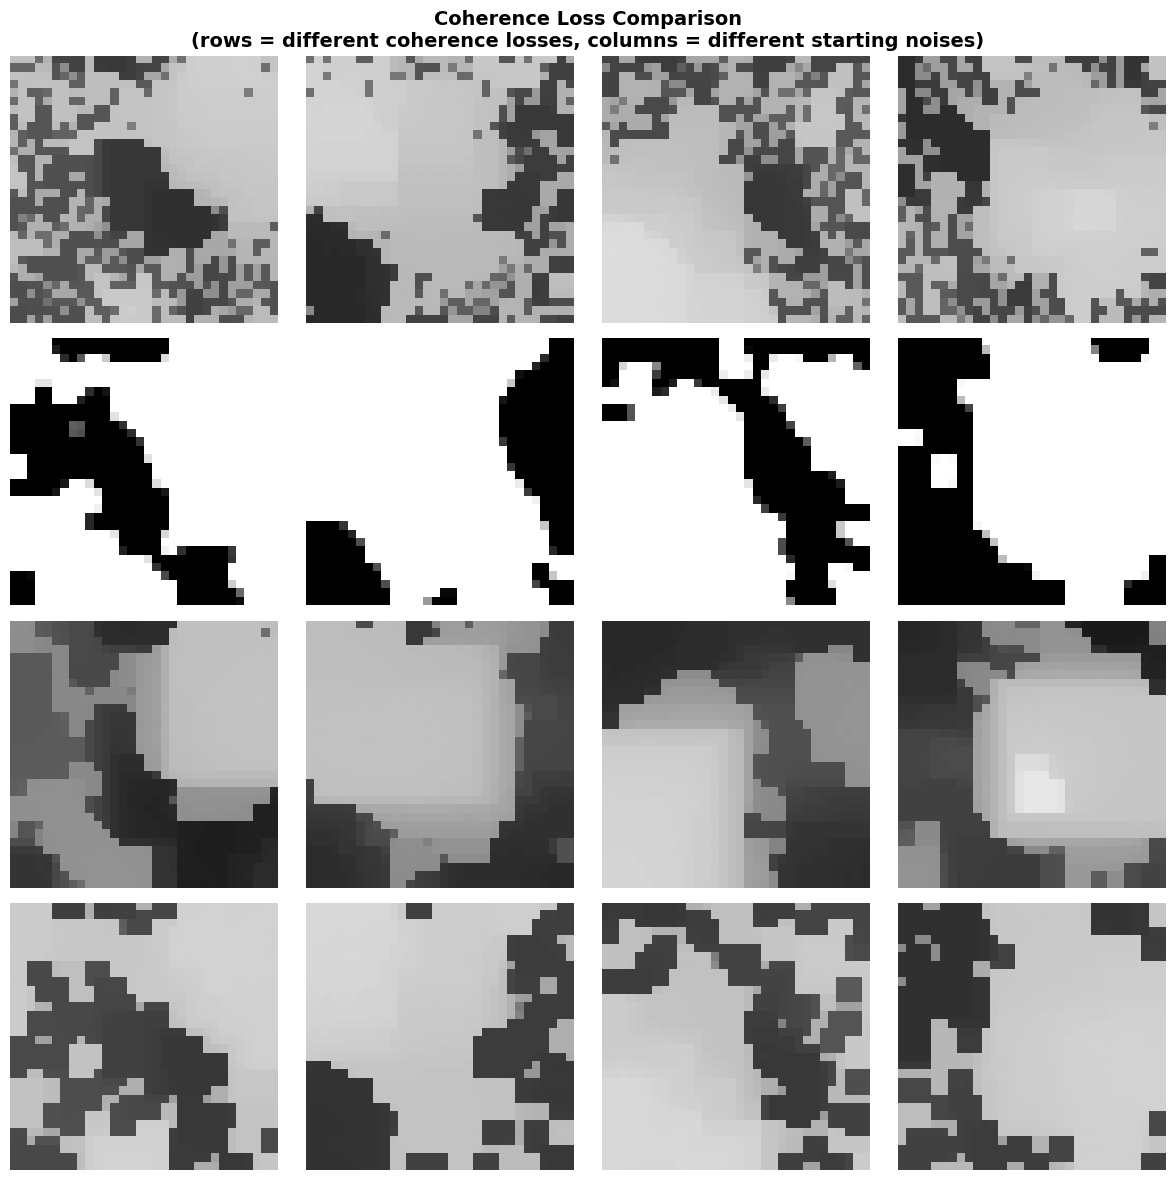


Notice how coherence losses create more connected blobs:
  - 'none': May have scattered pixels
  - 'autocorr': Smooth, connected blobs
  - 'perimeter': Compact, circular blobs
  - 'morphological': Robust blobs that survive pooling


In [12]:
# Compare all coherence loss types
print("Comparing coherence losses: None vs autocorr vs perimeter vs morphological\n")

coherence_types = [None, 'autocorr', 'perimeter', 'morphological']
results = {}

# Use same initial noise for fair comparison
torch.manual_seed(42)
np.random.seed(42)
initial_latents = initialize_latents(batch_size=4, device=device)

# First, visualize the initial latents
print("Initial latents (before optimization):\n")
fig_init, axes_init = plt.subplots(1, 4, figsize=(12, 3))
for col in range(4):
    img = initial_latents[col].detach().cpu().numpy()
    axes_init[col].imshow(img, cmap='gray', vmin=-1.5, vmax=1.5)
    axes_init[col].set_title(f'Initial {col+1}', fontsize=10)
    axes_init[col].axis('off')
plt.suptitle('Initial Random Noise (same for all coherence types below)', 
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nOptimizing with different coherence losses...\n")

for coh_type in coherence_types:
    print(f"Training with coherence_type = {coh_type}...")
    
    # Copy initial latents
    latents = initial_latents.clone().detach()
    latents.requires_grad_(True)
    
    optimizer = torch.optim.Adam([latents], lr=0.02)
    
    for step in range(200):  # Shorter for comparison
        optimizer.zero_grad()
        
        shape_losses = create_shape_losses(latents)
        contrast_loss = contrastive_shape_loss(latents)
        
        # Compute coherence loss
        if coh_type == 'autocorr':
            coh_loss = coherence_loss_autocorr(latents)
        elif coh_type == 'perimeter':
            coh_loss = coherence_loss_perimeter(latents)
        elif coh_type == 'morphological':
            coh_loss = coherence_loss_morphological(latents)
        else:
            coh_loss = torch.tensor(0.0)
        
        # Build total loss with comments explaining each component
        total_loss = (
            # Sparsity: encourages most pixels → 0 (background)
            0.0 * shape_losses['sparsity'] +
            
            # Binary: pushes pixels toward -1 or +1 (sharp black/white)
            1.0 * shape_losses['binary'] +
            
            # Total Variation: smoothness within regions (penalizes edges)
            0.5 * shape_losses['tv'] +
            
            # Object Size: enforces target ratio of bright pixels (~20%)
            0.1 * shape_losses['object_size'] +
            
            # Magnitude: prevents collapse to near-zero values
            5.0 * shape_losses['magnitude'] +
            
            # Contrastive: different samples should look different
            2.0 * contrast_loss
        )
        
        if coh_type:
            # Coherence: encourages spatially connected blobs vs scattered pixels
            total_loss += 5.0 * coh_loss
        
        total_loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            latents.clamp_(-1.5, 1.5)
    
    results[coh_type if coh_type else 'none'] = latents.detach().cpu()
    print(f"  ✓ Complete\n")

# Visualize comparison
print("="*70)
print("RESULTS AFTER 200 STEPS OF OPTIMIZATION")
print("="*70)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for row, coh_type in enumerate(['none', 'autocorr', 'perimeter', 'morphological']):
    for col in range(4):
        img = results[coh_type][col].numpy()
        axes[row, col].imshow(img, cmap='gray', vmin=-1.5, vmax=1.5)
        
        if col == 0:
            axes[row, col].set_ylabel(f"{coh_type}", fontsize=12, fontweight='bold')
        
        axes[row, col].axis('off')

plt.suptitle('Coherence Loss Comparison\n(rows = different coherence losses, columns = different starting noises)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nNotice how coherence losses create more connected blobs:")
print("  - 'none': May have scattered pixels")
print("  - 'autocorr': Smooth, connected blobs")
print("  - 'perimeter': Compact, circular blobs")
print("  - 'morphological': Robust blobs that survive pooling")

## Advanced: Compare All Coherence Losses Side-by-Side

Run this cell to see how different coherence losses affect the results:

In [4]:
latents

tensor([[[-2.2153e-02, -5.8354e-02, -2.1117e-02,  ..., -6.5220e-02,
           6.8553e-02, -7.1042e-03],
         [ 1.9378e-02,  8.2603e-02, -1.7751e-01,  ...,  7.4161e-03,
           5.6133e-02, -8.3895e-02],
         [ 3.1430e-01, -5.3456e-02, -5.9651e-02,  ...,  2.6908e-02,
           1.3192e-01, -8.5550e-02],
         ...,
         [-3.5411e-02, -1.2701e-01,  1.3651e-01,  ...,  1.5260e-01,
           8.8932e-02, -3.7377e-02],
         [-1.9339e-01, -5.0656e-02,  9.5146e-02,  ...,  6.8578e-02,
           4.1310e-02,  4.7853e-02],
         [ 8.3122e-02, -9.2290e-04, -9.4863e-02,  ...,  1.5116e-01,
           9.9019e-02,  1.2033e-01]],

        [[-9.5543e-02, -9.3216e-02,  2.7342e-02,  ...,  4.4466e-02,
          -1.1996e-01,  4.2614e-02],
         [-2.8725e-01,  2.3137e-01,  7.2965e-02,  ...,  3.7599e-02,
          -1.8232e-01,  9.2461e-02],
         [-2.0442e-02,  3.7452e-02, -8.7801e-02,  ..., -3.7628e-02,
          -3.7383e-02, -5.3629e-03],
         ...,
         [ 2.0034e-02,  1